# Anomaly/Outlier Detection

#### Tasks to perform
- Identify the top 1% outliers: adopt at least three different methods
from different families (e.g., density-based, angle-based…) and
compare the results.
- Visualize the outliers in a 2 or 3d scatter plot using at least one
dimensionality reduction technique.
- Deal with the outliers in a way you see fit, e.g. by removing them from
the dataset or by treating the anomalous variables as missing values
and employing replacement techniques. In this second case, you
should check that the outliers are not outliers anymore. Justify your
choices in every step.

In [190]:
#importing libraries
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# data visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 300)

## Data Preparation for OD

In [191]:
# Importing dataset with 12 best feats from RFE + target (vocal_channel)
path = 'data\data_for_AD'
df = pd.read_csv(path)
print(len(df))
df.head()

2452


,emotion_disgust,frame_count,sc_max,sc_q25,sc_q50,kur_w1,sc_kur_w1,stft_kur_w1,mfcc_kur_w2,sc_mean_w2,sc_q25_w2,mfcc_q05_w3,mfcc_kur_w3,kur_w4,zc_sum_w4,sc_min_w4,vocal_channel
0,0,0.106792,0.705391,0.560393,0.927656,0.572236,0.692039,0.503824,0.438077,0.405315,0.385595,0.801812,0.481993,0.290004,0.448805,0.000000,speech
1,0,0.116504,0.450510,0.561798,0.799551,0.435323,0.638155,0.192102,0.457699,0.420190,0.394864,0.852725,0.449225,0.339563,0.396224,0.869244,speech
2,0,0.097081,0.459613,0.472504,0.911578,0.100512,0.494276,0.131463,0.540126,0.474156,0.294100,0.820192,0.451288,0.298100,0.361620,0.000000,speech
3,0,0.067960,0.453229,0.537759,0.841966,0.107666,0.055930,0.115819,0.590455,0.556900,0.309099,0.838101,0.441262,0.292879,0.492813,0.871873,speech
4,0,0.174752,0.598407,0.505940,0.733857,0.430345,0.767877,0.615396,0.419206,0.404362,0.351926,0.868720,0.365163,0.293666,0.461552,0.819687,speech


In [192]:
target = df.pop('vocal_channel')
df.insert(0, 'vocal_channel', target)
df_train, df_test = df.loc[:1827,:], df.loc[1828:,:]
df.head()

,vocal_channel,emotion_disgust,frame_count,sc_max,sc_q25,sc_q50,kur_w1,sc_kur_w1,stft_kur_w1,mfcc_kur_w2,sc_mean_w2,sc_q25_w2,mfcc_q05_w3,mfcc_kur_w3,kur_w4,zc_sum_w4,sc_min_w4
0,speech,0,0.106792,0.705391,0.560393,0.927656,0.572236,0.692039,0.503824,0.438077,0.405315,0.385595,0.801812,0.481993,0.290004,0.448805,0.000000
1,speech,0,0.116504,0.450510,0.561798,0.799551,0.435323,0.638155,0.192102,0.457699,0.420190,0.394864,0.852725,0.449225,0.339563,0.396224,0.869244
2,speech,0,0.097081,0.459613,0.472504,0.911578,0.100512,0.494276,0.131463,0.540126,0.474156,0.294100,0.820192,0.451288,0.298100,0.361620,0.000000
3,speech,0,0.067960,0.453229,0.537759,0.841966,0.107666,0.055930,0.115819,0.590455,0.556900,0.309099,0.838101,0.441262,0.292879,0.492813,0.871873
4,speech,0,0.174752,0.598407,0.505940,0.733857,0.430345,0.767877,0.615396,0.419206,0.404362,0.351926,0.868720,0.365163,0.293666,0.461552,0.819687


In [193]:
X_cont_only = df.iloc[:,2:].values
X_w_emdisg = df.iloc[:,1:].values
y = np.array(df['vocal_channel'])

# OD Algorithms

## Visual Approaches

### Boxplots

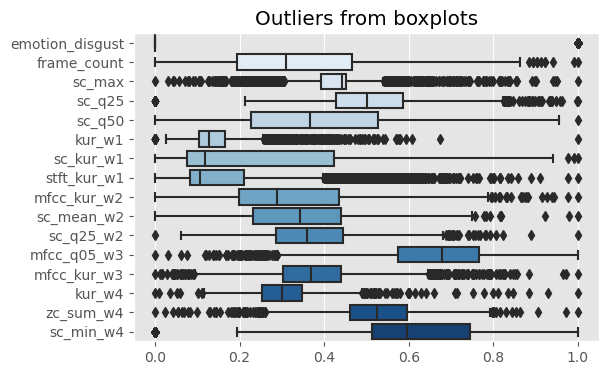

In [194]:
# General Boxplots
plt.figure(figsize=(6, 4))
sns.boxplot(data = df, orient = 'h', palette = 'Blues', )
plt.title(f'Outliers from boxplots')
plt.yticks()
plt.show()

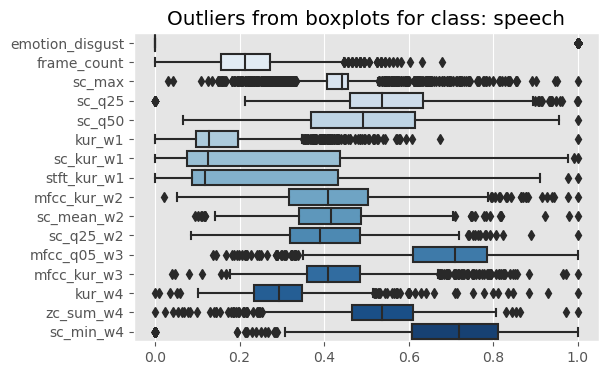

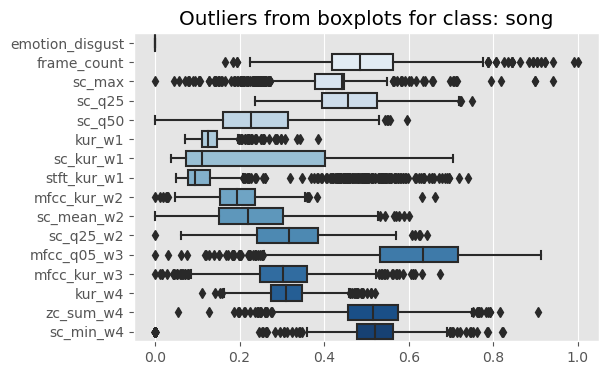

In [195]:
# Boxplots for every feature
for c in [x for x in df['vocal_channel'].unique()]:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data = df[df['vocal_channel']==c], orient="h", palette = 'Blues', )
    plt.title(f'Outliers from boxplots for class: {c}')
    plt.yticks()
    plt.show()

### Automatic BoxPlot

In [196]:
def idxOutlier(feature, k = 1.5):
    q1 = np.quantile(feature, 0.25)
    q3 = np.quantile(feature, 0.75)
    iqr = q3-q1
    outliers = []
    for i in range(len(feature)):
        if (feature[i] < q1 - k*iqr) or (feature[i] > q3 + k*iqr):
            outliers.append(i)
        else:
            continue
    return outliers

In [197]:
# Dict of outliers and respective record index for each variable 
all_out = {}
for feat in df.loc[:,'frame_count':].columns:
    o = idxOutlier(df[feat].to_numpy(), 1.5)
    all_out[feat] = o
    
for d in all_out.keys():
    print(d, len(all_out[d]))

frame_count 11
sc_max 439
sc_q25 57
sc_q50 1
kur_w1 241
sc_kur_w1 3
stft_kur_w1 536
mfcc_kur_w2 20
sc_mean_w2 10
sc_q25_w2 26
mfcc_q05_w3 72
mfcc_kur_w3 111
kur_w4 53
zc_sum_w4 66
sc_min_w4 169


In [198]:
out_idx = []
for f in all_out.keys():
    out_idx.append(set(all_out[f]))
    
print(out_idx) # Looks like there are no outliers coinciding over all the variables

[{897, 2210, 484, 485, 487, 903, 173, 174, 175, 589, 913}, {0, 4, 8, 2056, 10, 11, 12, 2061, 2073, 33, 40, 41, 42, 43, 2093, 51, 2104, 2106, 69, 91, 92, 94, 95, 2143, 2146, 2148, 2151, 105, 2156, 2158, 111, 117, 118, 125, 2186, 139, 2188, 143, 2192, 2195, 2196, 153, 2202, 157, 162, 172, 175, 190, 193, 194, 2248, 207, 2255, 216, 217, 219, 220, 221, 2269, 2270, 224, 225, 226, 227, 2272, 234, 2286, 239, 240, 241, 242, 2289, 245, 2294, 248, 2296, 250, 251, 2300, 2301, 256, 257, 259, 2311, 2314, 2315, 272, 274, 275, 276, 277, 278, 280, 281, 284, 285, 286, 287, 294, 298, 299, 300, 302, 303, 304, 305, 2352, 307, 308, 309, 310, 311, 312, 2353, 2357, 2362, 2370, 2379, 343, 2392, 2394, 357, 2416, 378, 2437, 419, 456, 478, 509, 554, 560, 561, 576, 604, 606, 612, 613, 621, 633, 640, 641, 643, 648, 650, 656, 658, 659, 665, 674, 732, 736, 738, 741, 742, 743, 745, 751, 752, 754, 755, 758, 761, 762, 763, 765, 772, 773, 774, 779, 781, 784, 791, 796, 799, 807, 820, 823, 824, 827, 829, 832, 842, 848, 849

### HBOS

In [199]:
from pyod.models.hbos import HBOS

# HBOS with automatic Birge-Rozenblac number of bins selection for each feature
# Contamination set to 1% since we want the top 1% outliers
clf = HBOS(contamination = 0.01)
clf.fit(X_w_emdisg)
print(f'outlier score for each data object:\n{clf.decision_scores_}')


outlier score for each data object:
[ -6.19977978 -14.28818765 -15.34318886 ... -23.93234717 -25.1537738
 -21.13043717]


In [200]:
# Predicting ouliers
outliers = clf.predict(X_w_emdisg)

# Saving indices of detected outliers
outs = [i for i,x in enumerate(outliers) if x == 1]
print(f'there are {len(outs)} outliers\noutliers\' indices :{outs}')

there are 25 outliers
outliers' indices :[256, 346, 869, 878, 1092, 1095, 1096, 1295, 1358, 1390, 1704, 1706, 1800, 1801, 1825, 1878, 1938, 1968, 1982, 2104, 2272, 2276, 2289, 2291, 2392]


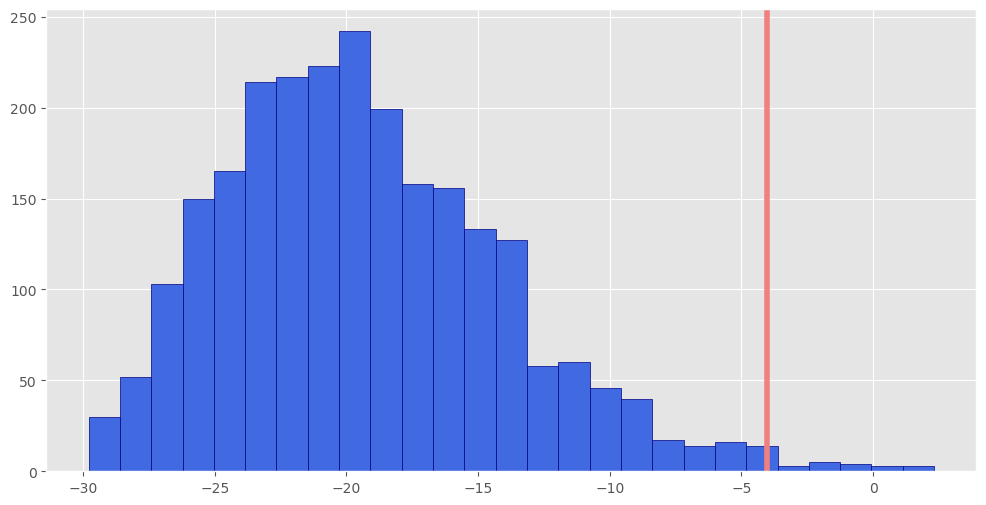

In [201]:
from math import ceil
# Number of histogram's bins calculated with Sturge's Rule
plt.figure(figsize = (12,6))
plt.hist(clf.decision_scores_, bins=ceil(1 + 3.322 * np.log(len(df))), color='royalblue', edgecolor = 'navy')
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), color = 'lightcoral', linewidth = '4')
plt.show()

## Statistical-based Approaches

### Grubb's Test

In [202]:
import numpy as np
from scipy import stats
cols = df.columns[2:]

outl = {}
for d in range(len(X_cont_only[0])):
    ou = []
    print(f'outliers and first inlier for {cols[d]}')
    data = X_cont_only[:,d]
    for i in range(len(X_cont_only)):
        print(f'length of the dataset: {len(data)}')
        alpha = 0.95
        n = len(data)
        significance_level = alpha / (2*n)
        t = stats.t.isf(significance_level, n-2, 2)
        g_test = ((n-1) / np.sqrt(n)) * (np.sqrt(t**2 / (n-2 + t**2)))
        absv = abs(data - data.mean())
        index = absv.argmax()
        maxx = absv[index]
        g = maxx / data.std()
        if g > g_test:
            print(f'## outlier\n value: {g}\n index: {index}')
            ou.append(index)
            data = np.delete(data, index)
        else:
            print(f'## inlier\n value: {g}')
            break
    outl[cols[d]] = ou
    print('________________________________________________')

outliers and first inlier for frame_count
length of the dataset: 2452
## inlier
 value: 3.8127903963562386
________________________________________________
outliers and first inlier for sc_max
length of the dataset: 2452
## outlier
 value: 5.620375659902935
 index: 1932
length of the dataset: 2451
## inlier
 value: 5.172407274183586
________________________________________________
outliers and first inlier for sc_q25
length of the dataset: 2452
## inlier
 value: 3.922214174050976
________________________________________________
outliers and first inlier for sc_q50
length of the dataset: 2452
## inlier
 value: 3.0883148135007423
________________________________________________
outliers and first inlier for kur_w1
length of the dataset: 2452
## outlier
 value: 10.278473996168849
 index: 1968
length of the dataset: 2451
## outlier
 value: 6.4693232011984305
 index: 1409
length of the dataset: 2450
## outlier
 value: 5.7037123466065465
 index: 1968
length of the dataset: 2449
## outlier
 v

In [203]:
# Outliers indices for each considered feature
print(f'Outliers indices for each feature:\n {outl}')

Outliers indices for each feature:
 {'frame_count': [], 'sc_max': [1932], 'sc_q25': [], 'sc_q50': [], 'kur_w1': [1968, 1409, 1968, 148], 'sc_kur_w1': [], 'stft_kur_w1': [], 'mfcc_kur_w2': [], 'sc_mean_w2': [], 'sc_q25_w2': [], 'mfcc_q05_w3': [], 'mfcc_kur_w3': [], 'kur_w4': [361, 2360, 156, 2151, 1404, 876, 1407, 1395, 124], 'zc_sum_w4': [], 'sc_min_w4': []}


### Likelihood Approach

In [204]:
# Should we try it? Many assumptions on the data's distribution!!

## Depth-based Approaches

### Convex Hulls

In [205]:
# Don't know how to do these

### Elliptic Envelope

In [206]:
from sklearn.covariance import EllipticEnvelope
import matplotlib.font_manager

# Contamination set at 1% since we want to find the top 1% of outliers
out_perc = 0.01
ell_env = EllipticEnvelope(contamination = out_perc)
ell_env.fit(X_w_emdisg)
scores = ell_env.decision_function(X_w_emdisg)

# -1 -> outliers, 1 -> normal data objects, 
outliers = ell_env.predict(X_w_emdisg)
print(np.unique(outliers, return_counts=True))
ind = np.where(outliers == -1)

(array([-1,  1]), array([  25, 2427], dtype=int64))


In [207]:
# Performing PCA only for viz purposes
# Don't know if I've done something sensible
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_w_emdisg)
print(pca.explained_variance_)
X_pca = pca.transform(X_w_emdisg)
print(X_pca.shape)


[0.12185238 0.0689611 ]
(2452, 2)


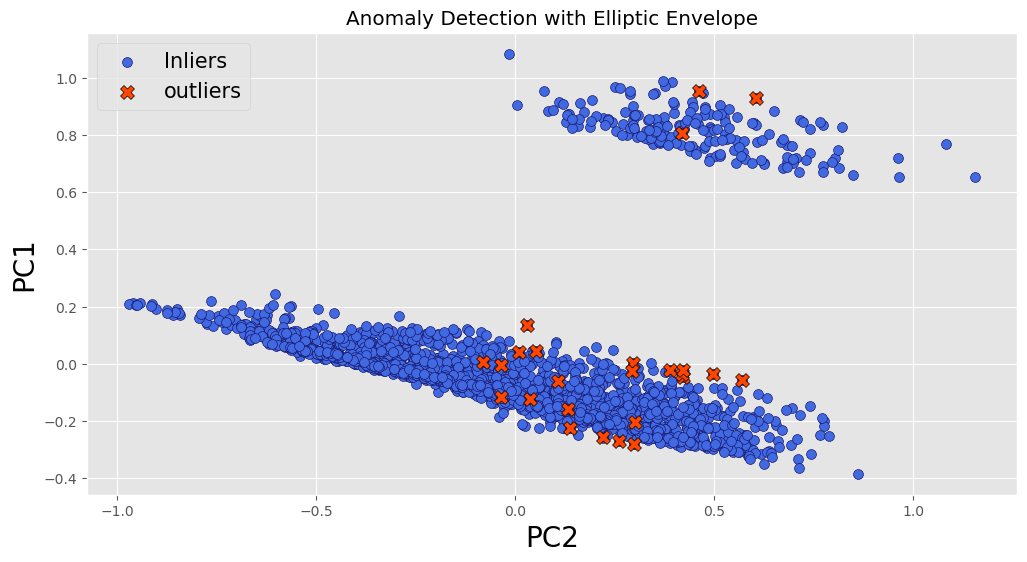

In [208]:
plt.scatter(X_pca[:,0], X_pca[:,1], color = 'royalblue', edgecolors='midnightblue', s = 50, label = 'Inliers')
plt.scatter(X_pca[ind][:,0], X_pca[ind][:,1], color='orangered', edgecolors='k', marker = 'X', s = 100, label = 'outliers')
plt.title('Anomaly Detection with Elliptic Envelope')
plt.ylabel('PC1', fontsize = 20)
plt.xlabel('PC2', fontsize = 20)
plt.legend(fontsize = 15, loc = 'upper left')
plt.show()

In [209]:
print(f'indices of the {out_perc} top outliers:\n{ind}')

indices of the 0.01 top outliers:
(array([   0,    8,   55,  148, 1292, 1367, 1409, 1768, 1772, 1779, 1781,
       1789, 1938, 1953, 1954, 1968, 1969, 1970, 2262, 2272, 2283, 2289,
       2302, 2353, 2400], dtype=int64),)


## Deviation-based Approach

### Smoothing Factor (variance)

In [210]:
from copy import deepcopy

# Using variance decrease for each feature as smoothing factor to evaluate top outliers
def sf(x, X):
    idx = list(X).index(x)
    X1 = np.array([x1 for i, x1 in enumerate(X) if i != idx])
    return np.abs(np.var(X) - np.var(X1))

data = deepcopy(X_cont_only) 

scores = {}
for n in range(len(cols)):
    outl = []
    for i, x in enumerate(data[:,n]):
        outl.append([i,sf(x,data[:,n])])
    scores[cols[n]] = outl

In [211]:
# Taking the top 10 SF values for each feature
#  (this means the 10 biggest outliers for each feature)
top_10 = {}
for k in scores.keys():
    top_10[k] = (sorted(scores[k], key = lambda vals: vals[1], reverse = True)[:10])
print(top_10)

{'frame_count': [[2210, 0.00016741819198870175], [589, 0.00016219544370542002], [485, 0.00013724246669910567], [175, 0.00012780048069737857], [484, 0.00012780048069737857], [173, 0.0001231963187838872], [913, 0.00011866624188386007], [897, 0.00011866343816322941], [174, 0.00011421314982883526], [487, 0.00011421314982883526]], 'sc_max': [[1932, 0.00013070419423670543], [2192, 0.00010851743460268612], [153, 0.00010631002537861943], [827, 0.00010424610193425152], [981, 8.814228457697075e-05], [1636, 8.69322628800108e-05], [2437, 8.690988482129222e-05], [2158, 8.459293172773455e-05], [745, 7.138071061718251e-05], [2093, 7.091754654315122e-05]], 'sc_q25': [[314, 9.980868770607249e-05], [315, 9.980868770607249e-05], [324, 9.980868770607249e-05], [1367, 9.980868770607249e-05], [1597, 9.980868770607249e-05], [1934, 9.980868770607249e-05], [1938, 9.980868770607249e-05], [1939, 9.980868770607249e-05], [1940, 9.980868770607249e-05], [1953, 9.980868770607249e-05]], 'sc_q50': [[53, 0.00013641640341

## Distance-based Approaches

### kNN for Outlier Detection

Do we perform the PCA before employing distance and density based OD algorithms??

(Also, as we can see, the first two Principal Components don't explain any relevant variability in the data [12% PC1 and 7% PC2])

In [212]:
# Performing a PCA before implementing such approaches
# since they suffer from the Curse of Dimensionality
pca = PCA(n_components=2)
pca.fit(X_w_emdisg)
print(pca.explained_variance_)
X_pca = pca.transform(X_w_emdisg)
print(X_pca.shape)

[0.12185238 0.0689611 ]
(2452, 2)


#### Normal kNN (only choosing k and taking top 1% outliers based on that)

1-NN
(array([0]), array([2452], dtype=int64))
there are 0 outliers
outliers' indices :[]
No Outliers to plot


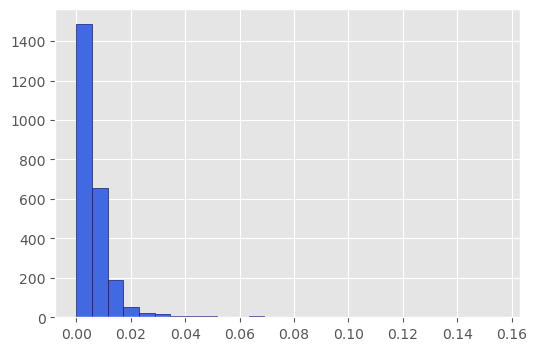

____________________________________________________________________
3-NN
(array([0, 1]), array([2435,   17], dtype=int64))
there are 17 outliers
outliers' indices :[8, 880, 985, 987, 1099, 1293, 1294, 1295, 1299, 1321, 1390, 1968, 2277, 2289, 2290, 2291, 2392]


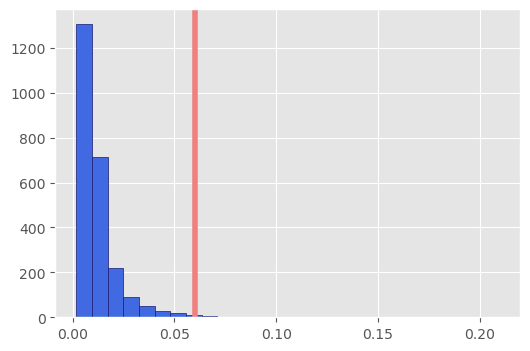

____________________________________________________________________
5-NN
(array([0, 1]), array([2438,   14], dtype=int64))
there are 14 outliers
outliers' indices :[8, 985, 987, 1293, 1294, 1295, 1299, 1390, 1970, 2277, 2289, 2290, 2291, 2392]


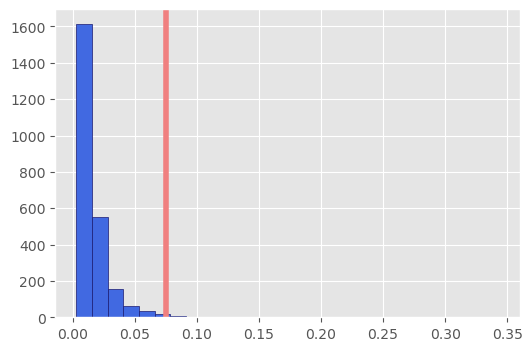

____________________________________________________________________
7-NN
(array([0, 1]), array([2436,   16], dtype=int64))
there are 16 outliers
outliers' indices :[8, 152, 878, 985, 987, 1191, 1293, 1294, 1295, 1299, 1390, 2277, 2289, 2290, 2291, 2392]


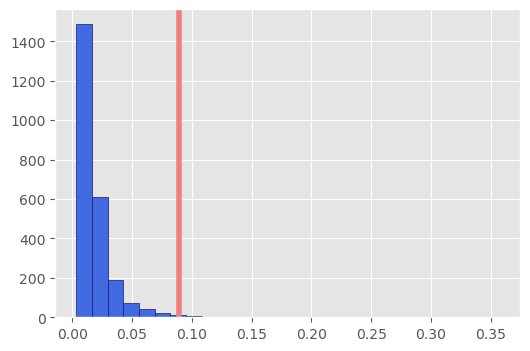

____________________________________________________________________


In [213]:
from pyod.models.knn import KNN

# Setting the type of metric we want to use for the kNN computationù
distance_type = 'euclidean'

# Choosing k and setting 1% as fraction of outliers in the dataset
for n in range(1,8,2):
    print(f'{n}-NN')
    knn = KNN(n_neighbors=n, metric = distance_type, contamination = 0.01)
    knn.fit(X_pca)

    # 0 -> Inliers, 1 -> Outliers
    outliers = knn.predict(X_pca)
    outs_idx = [i for i,x in enumerate(outliers) if x == 1]
    print(np.unique(outliers, return_counts=True))
    print(f'there are {len(outs_idx)} outliers\noutliers\' indices :{outs_idx}')

    # Visualizing the results of kNN in terms of outlier score
    plt.figure(figsize = (6,4))
    plt.hist(knn.decision_scores_, bins=ceil(1 + 3.322 * np.log(len(df))), color = 'royalblue', edgecolor = 'midnightblue')
    try:
        plt.axvline(np.min(knn.decision_scores_[np.where(outliers==1)]), c='lightcoral', linewidth = 4)
    except:
        print('No Outliers to plot')
    plt.show()
    print('____________________________________________________________________')

#### Outlier scoring based on the mean of different kNN distances for each object

In [214]:
from sklearn.neighbors import NearestNeighbors

# To determine the outliers, let's compute the mean distance for each instance 
# for different k in some range
k_dist = np.zeros(len(X_pca))
for k in range(2,22):
    k -= 1
    #print(f'Distance from {k}th NN for all the instances')
    nbrs = NearestNeighbors(n_neighbors = k, metric = distance_type)
    nbrs.fit(X_pca)

    # Distances and indexes of k-neaighbors from model outputs
    distances, indexes = nbrs.kneighbors(X_pca)
    #print(np.max(distances, axis = 1))
    k_dist = np.vstack([k_dist,np.max(distances, axis = 1)])

k_dist = k_dist[1:]
k_dist_mean = np.mean(k_dist, axis = 0)
print(f'Mean distance from 1NN to {k}NN for each instance {k_dist_mean}')

Mean distance from 1NN to 20NN for each instance [0.0544584  0.0305433  0.01907358 ... 0.01338334 0.0099964  0.01058101]


In [215]:
# Taking the n_biggest_o data objects with the largest mean distances from the kNNs (in the range above)
n_biggest_o = 25
outs_idxs = np.argsort(k_dist_mean)[::-1][:n_biggest_o]

print(f'outliers\' indices :\n{outs_idxs}\nvalues:\n{k_dist_mean[outs_idxs]}')

outliers' indices :
[2291 1295 2392 2290 1390 1294  985 1293 1299  987 2289  897 2260 1191
  878 2277    8 1301  485  880 2281  871 1298 1099 1814]
values:
[0.34515711 0.27591124 0.24111403 0.19557361 0.19331232 0.18218234
 0.13626102 0.12180095 0.11767074 0.10790015 0.10495024 0.10224145
 0.09950593 0.09885408 0.09687535 0.09672051 0.096195   0.09535139
 0.09481989 0.09347875 0.09282534 0.09227833 0.09206912 0.0898933
 0.08985689]


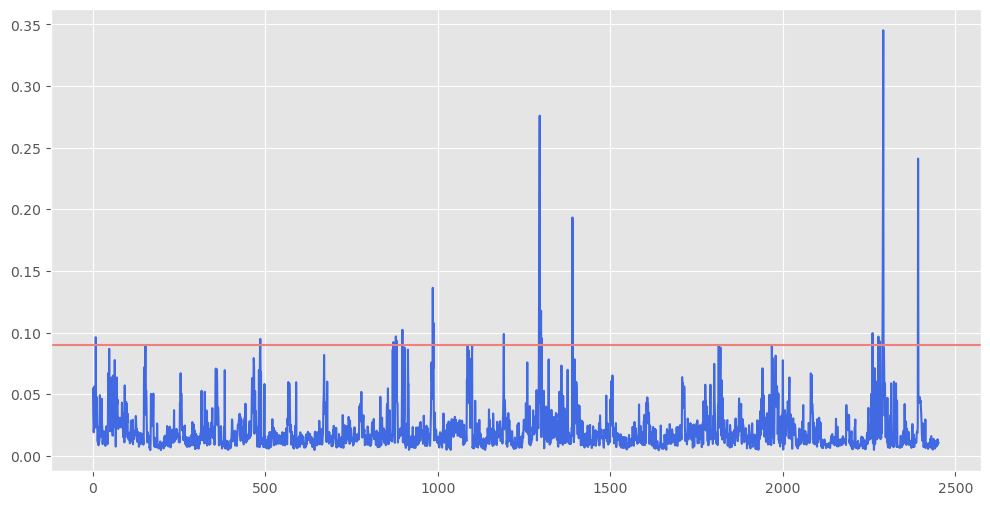

In [216]:
# Plotting the results
plt.plot(k_dist_mean, c = 'royalblue')
plt.axhline(np.min(k_dist_mean[outs_idxs]), c='lightcoral', linewidth = 1.5)
plt.show()
plt.close()


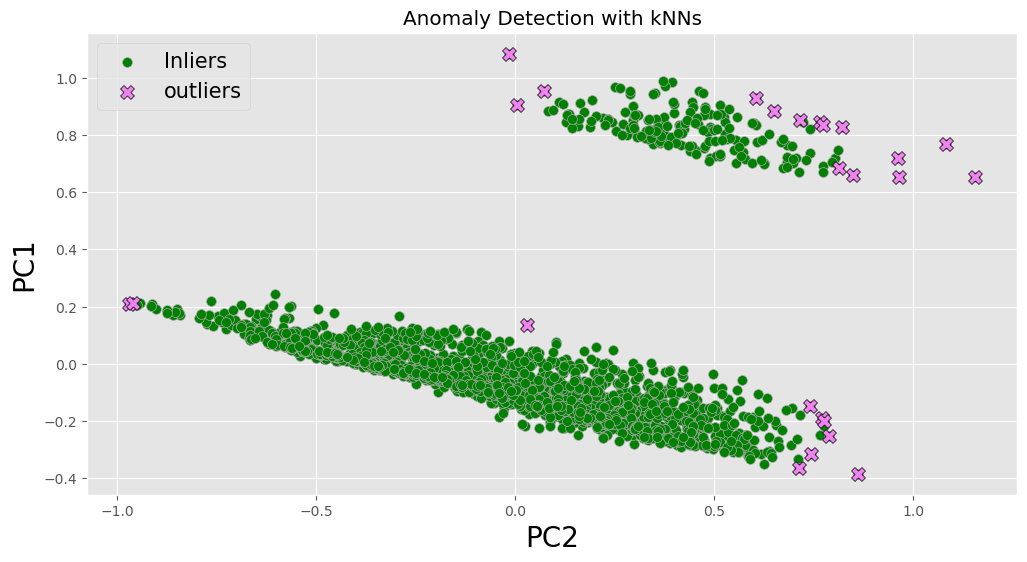

In [217]:
# Visualizing the first two PCs with a scatterplot
plt.scatter(X_pca[:,0], X_pca[:,1], color = 'green', edgecolors='darkgrey', s = 50, label = 'Inliers')
plt.scatter(X_pca[outs_idxs][:,0], X_pca[outs_idxs][:,1], color='violet', edgecolors='k', marker = 'X', s = 100, label = 'outliers')
plt.title('Anomaly Detection with kNNs')
plt.ylabel('PC1', fontsize = 20)
plt.xlabel('PC2', fontsize = 20)
plt.legend(fontsize = 15, loc = 'upper left')
plt.show()

### Reverse kNN (RkNN)

In [218]:
# Should we try it??

## Density-based Approaches

### DBSCAN

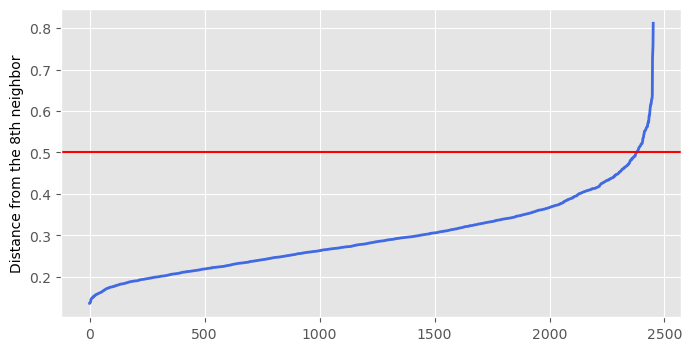

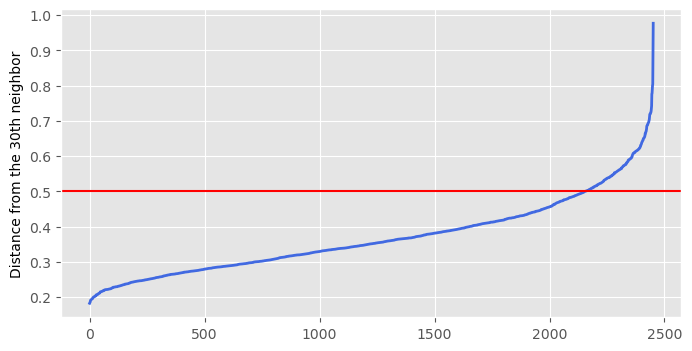

In [219]:
from scipy.spatial.distance import pdist, squareform

df_dbscan = df.loc[:,'frame_count':].copy(deep = True)
dist = pdist(df_dbscan, 'euclidean')
dist = squareform(dist)
k = 8
kth_distances = []
for d in dist:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances.append(d[index_kth_distance])  # store the distance in a list
plt.figure(figsize = (8,4))
plt.plot(range(0, len(kth_distances)), sorted(kth_distances), color = 'royalblue', linewidth = 2)
plt.ylabel('Distance from the {}th neighbor'.format(k))
plt.axhline(y=0.5, color='r', linestyle='-')
plt.show()
plt.close()
k=30
kth_distances = []
for d in dist:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances.append(d[index_kth_distance]) 
plt.figure(figsize = (8,4))
plt.plot(range(0, len(kth_distances)), sorted(kth_distances), color = 'royalblue', linewidth = 2)
plt.ylabel('Distance from the {}th neighbor'.format(k))
plt.axhline(y=0.5, color='r', linestyle='-')
plt.show()
plt.close()

DBSCAN parameters: eps = 0.47, k = 10
(array([-1,  0], dtype=int64), array([  22, 2430], dtype=int64))
there are 22 outliers
outliers' indices :[40, 426, 878, 1376, 1411, 1796, 1800, 1801, 1802, 1819, 1824, 1932, 1938, 1968, 1969, 1982, 2249, 2252, 2272, 2291, 2383, 2392]


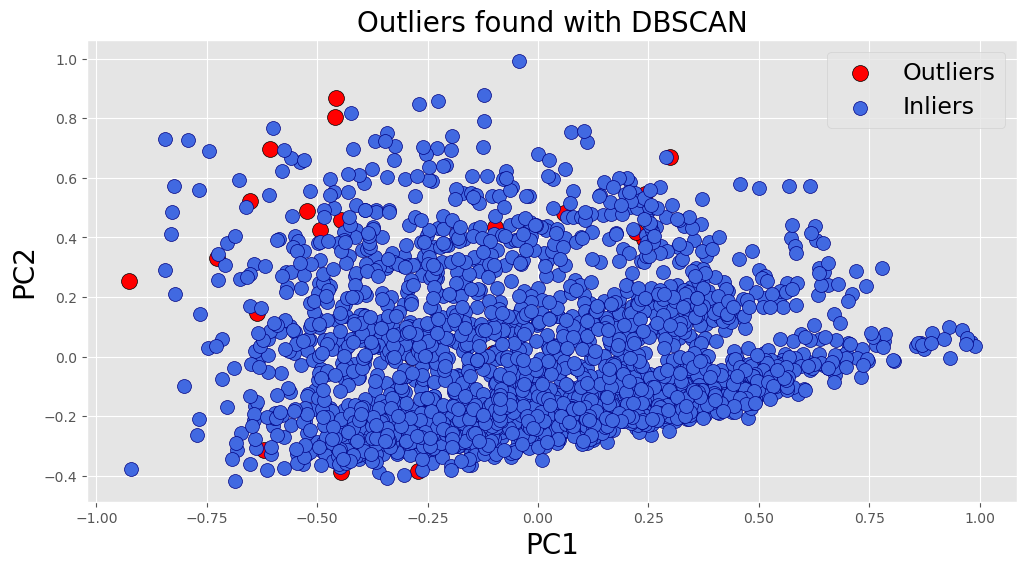

In [220]:
from sklearn.cluster import DBSCAN

# Hyperparameters selected looking at kth-distance
e, min_s = 0.47, 10
print(f'DBSCAN parameters: eps = {e}, k = {min_s}')

# Employing the algorithm
dbscan = DBSCAN(eps=e, min_samples=min_s)
dbscan.fit(df_dbscan)
labels = dbscan.labels_
print(np.unique(labels, return_counts=True))
print(f'there are {len(df_dbscan[labels==-1])} outliers\noutliers\' indices :{list(df_dbscan[labels==-1].index)}')

# Performing a PCA only for viz purposes
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(df_dbscan)
principalDf = pd.DataFrame(data = principalComponents
                , columns = ['PC1', 'PC2', 'PC3'])
plt.scatter(principalDf[labels==-1]['PC1'], principalDf[labels==-1]['PC2'],
            label = 'Outliers', c = 'red', s = 130, edgecolors = 'k')
plt.scatter(principalDf[labels==0]['PC1'], principalDf[labels==0]['PC2'],
            label = 'Inliers', c = 'royalblue', s = 100, edgecolors = 'navy')
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.title('Outliers found with DBSCAN', fontsize = 20)
plt.legend(fontsize = 17, loc = 'upper right')
plt.xlabel('PC1', fontsize = 20)
plt.ylabel('PC2', fontsize = 20)
plt.show()

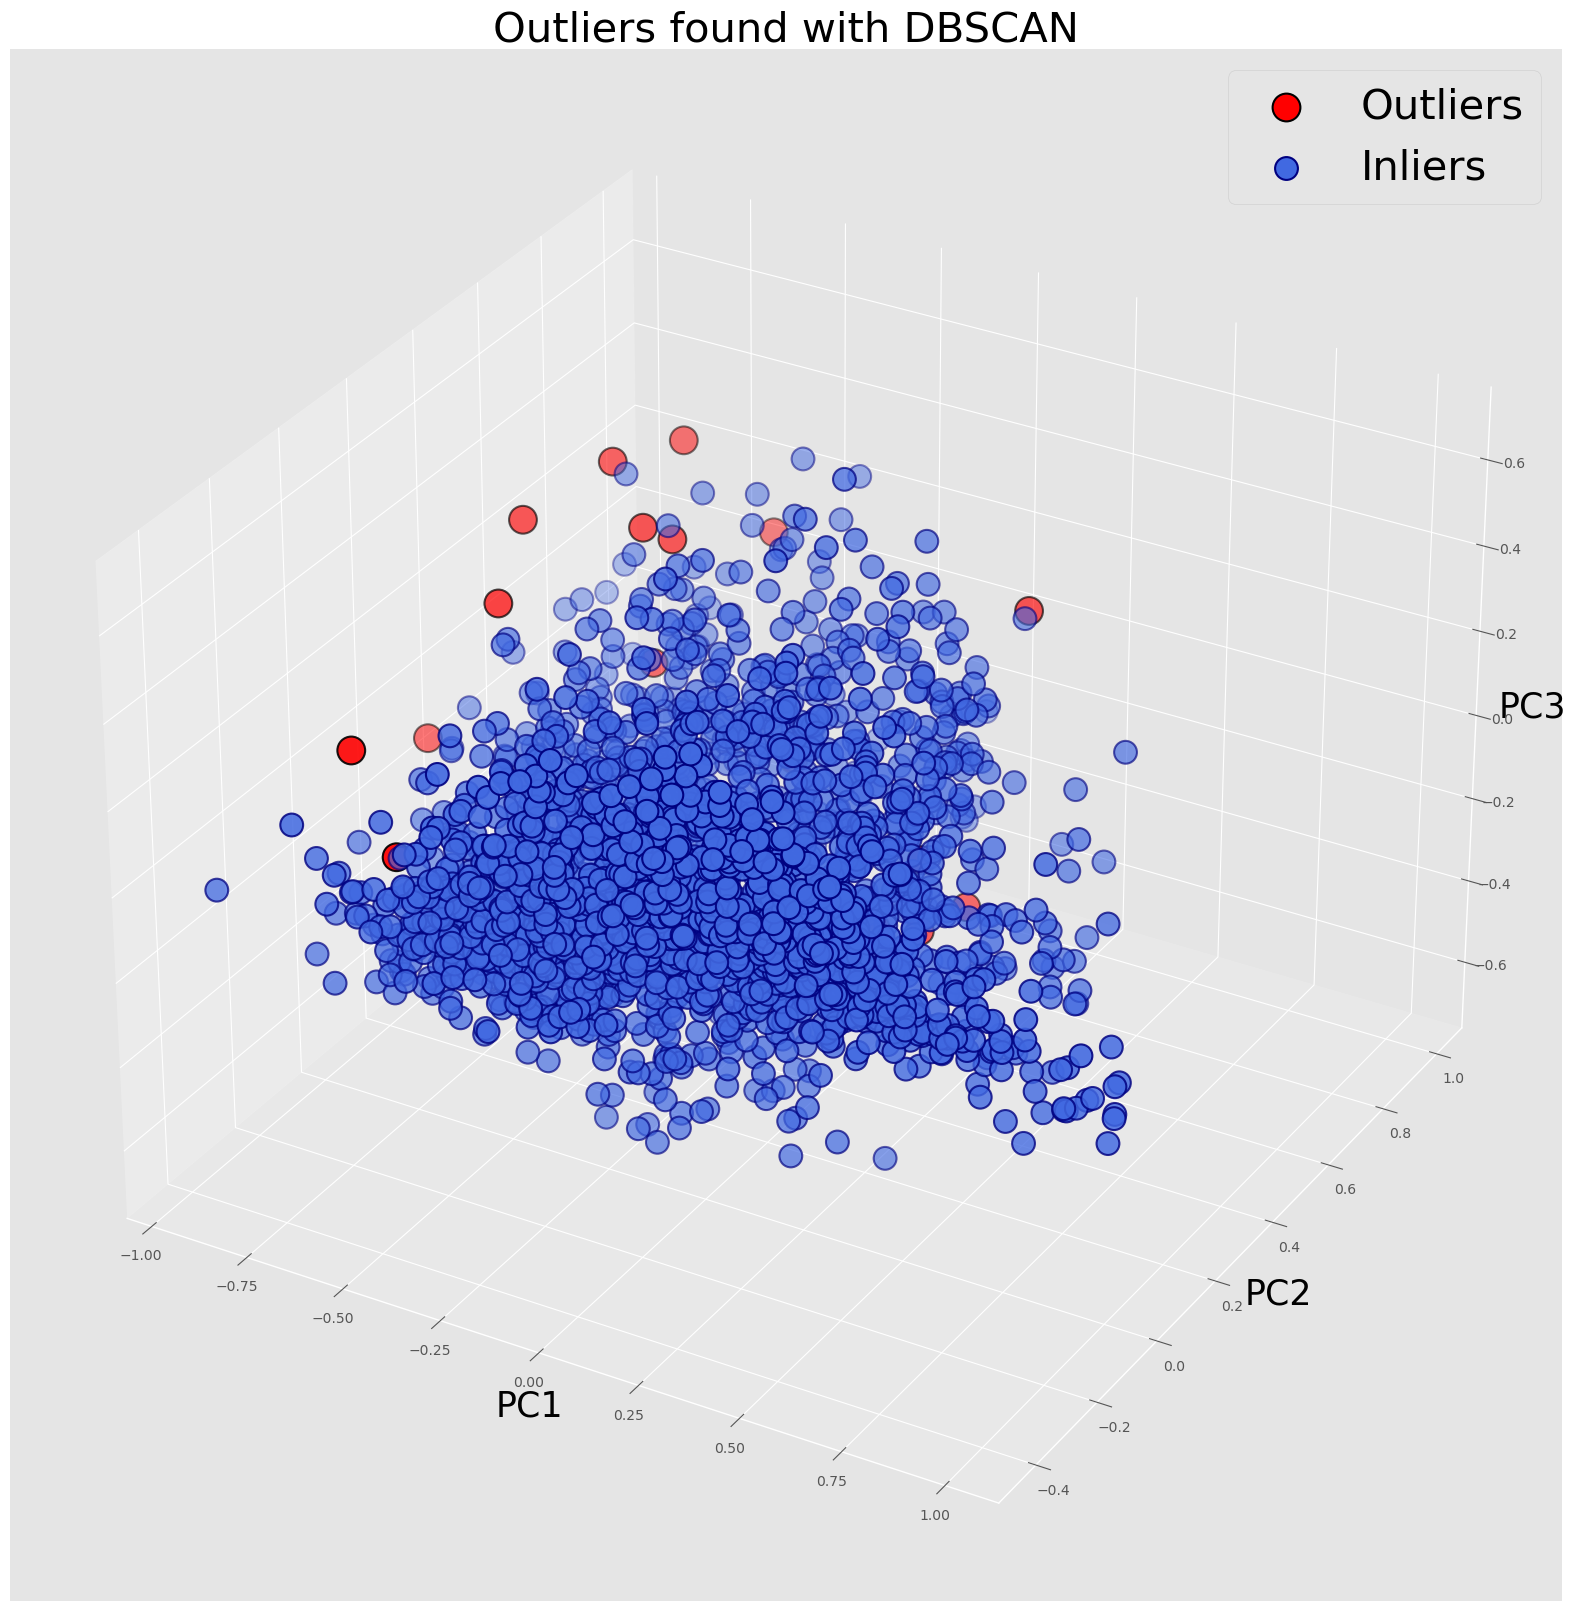

In [221]:

from mpl_toolkits import mplot3d

# 3D scatterplot of the data (Inliers and Outliers)
figure = plt.figure(figsize=(20,16), layout = 'constrained')
ax = plt.axes(projection='3d')

ax.scatter3D(principalDf[labels==-1]['PC1'], principalDf[labels==-1]['PC2'], principalDf[labels==-1]['PC3'],
              label = 'Outliers', c='red', edgecolors = 'k', linewidth = 1.5,s = 400)
ax.scatter3D(principalDf[labels==0]['PC1'], principalDf[labels==0]['PC2'], principalDf[labels==0]['PC3'],
              label = 'Inliers', c='royalblue', edgecolors = 'navy', linewidth = 1.5,s = 270)
plt.title("Outliers found with DBSCAN", fontsize = 30)

ax.set_xlabel('PC1', fontsize = 25)
ax.set_ylabel('PC2', fontsize = 25)
ax.set_zlabel('PC3', fontsize = 25)

plt.legend(fontsize = 30, loc = 'upper right')
plt.show()
plt.close()

In [222]:
outliers = list(df_dbscan[dbscan.labels_==-1].index)
print(f'Outliers indices: {outliers}')

Outliers indices: [40, 426, 878, 1376, 1411, 1796, 1800, 1801, 1802, 1819, 1824, 1932, 1938, 1968, 1969, 1982, 2249, 2252, 2272, 2291, 2383, 2392]


Obviously we have to exstract the outliers from all the algorithms used

Then we'll be able to determine if there are common results found through them all